# Анализ отзывов на основе модели word2vec

In [1]:
import json
import bz2
import regex
from tqdm import tqdm
from scipy import sparse
import pandas as pd
import numpy as np
import re
import nltk
from nltk import FreqDist
import matplotlib.pyplot as plt
import seaborn as sns
from pymystem3 import Mystem
from nltk.corpus import stopwords
import sqlite3
from gensim.models import Word2Vec
from sklearn.manifold import TSNE

%matplotlib inline
%pylab inline
from pprint import pprint

import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


#### Определяем функции

In [65]:
# 1. Токенизация
# задаём шаблон слова (слова с "Ё" или "ё" или с дефисом - выпадают из шаблона)
regex = re.compile("[А-Яа-я:=!\)\()A-z\_\%/|]+")
def words_only(text, regex=regex):
    try:
        return " ".join(regex.findall(text))
    except:
        return ""
    
# 2. Ф-ция разделения текста на токены без стоп-слов
mystopwords = stopwords.words('russian') + ['это', 'наш' , 'тыс', 'млн', 'млрд', 'также',  'т', 'д']
def  remove_stopwords(text, mystopwords = mystopwords):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""

# задаём морфологический анализатор
m = Mystem()
# 3. Ф-ция лемматизации
# для большого числа документов на порядок быстрее будет лемматизировать по батчам - 
# объединениям документов в батч перед подачей в лемматизатор
def smart_lemmatize(texts,batch_size=1000,mystem=m):
    lol = lambda lst, sz: [lst[i:i+sz] for i in range(0, len(lst), sz)]
    txtpart = lol(texts, batch_size)
    res = []
    for txtp in txtpart:
        alltexts = ' '.join([txt + ' brrr ' for txt in txtp])

        words = mystem.lemmatize(alltexts)
        doc = []
        for txt in words:
            if txt != '\n' and txt.strip() != '':
                if txt == 'brrr':
                    res.append(doc)
                    doc = []
                else:
                    doc.append(txt)
    return res
# объединяем отлематизированный список слов из текстов обратно в тексты
def join_lemm(lis):
    lis_sent = []
    for l in lis:
        lis_sent.append(" ".join(l).strip())
    return lis_sent

# 4. Ф-ция удаления стоп-лемм
mystoplemmas = ['который','прошлый','сей', 'свой', 'наш', 'мочь', 'такой']
def  remove_stoplemmas(text, mystoplemmas = mystoplemmas):
    try:
        return " ".join([token for token in text.split() if not token in mystoplemmas])
    except:
        return ""

In [2]:
responses = []
with bz2.BZ2File('dataNLP/banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [00:35, 5714.90it/s]


In [3]:
responses[99]

{'city': 'г. Саратов',
 'rating_not_checked': False,
 'title': 'Карта ко вкладу',
 'num_comments': 0,
 'bank_license': 'лицензия № 880',
 'author': 'ronnichka',
 'bank_name': 'Югра',
 'datetime': '2015-06-03 20:56:57',
 'text': 'Здравствуйте! Хотела написать, что мне месяц не выдают карту ко вкладу, ссылаясь на "нам же их из Самары везут" (на секундочку 5 часов езды от нашего города). Но! Прочитала, что людям 3,5 месяцев не выдают карту, и поняла, что у меня все хорошо, пока что. И подарок мне дали, и кулер в отделении есть. Так что я, конечно, готова ждать. Правда хотелось бы не очень долго.',
 'rating_grade': 3}

In [8]:
# переводим загруженные данные в датафрейм
resp_matrix = []
for resp in responses:
    resp_matrix.append([resp['text'],resp['rating_grade']])
df = pd.DataFrame(resp_matrix,columns=['text','rating'])
df.head()

,text,rating
0,Добрый день! Я не являюсь клиентом банка и пор...,NaN
1,Доброго дня! Являюсь держателем зарплатной кар...,NaN
2,Здравствуйте! Дублирую свое заявление от 03.0...,NaN
3,Добрый день!! Я открыл расчетный счет в СберБа...,NaN
4,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN


### 1. Разобьём всю коллекцию отзывов на предложения и отлемматизируем все слова.

In [86]:
corpus_sent = []
for txt in df.text:
    # убираем слова-сокращения типа "руб." и " г. "(вместо "г" любая буква), чтобы не портить алгоритм разбивки на предложения
    txt = re.sub("руб\.", '', txt)
    txt = re.sub("Юр\.", 'юридическое ', txt)
    txt = re.sub("юр\.", 'юридическое ', txt)
    txt = re.sub("физ\.", 'физическое ', txt)
    txt = re.sub("Физ\.", 'физическое ', txt)
    txt = re.sub(" [а-я]\. ", ' ', txt)
    # разбиваем на предложения
    txt_spl = re.split("\. |\.\.\. |!|\?", txt)
    # добавляем новые предложения в корпус предложений
    corpus_sent+=txt_spl
# очистим от пустых предложений
corpus_sent = list(filter(None, corpus_sent))

In [87]:
%%time
# очищаем предложения от мусора
corpus_sent = list(map(words_only,corpus_sent))
# очищаем предложения от стоп-слов
corpus_sent = list(map(remove_stopwords,corpus_sent))
# лемматизируем корпус предложений
lem_txt_list = smart_lemmatize(corpus_sent,batch_size=10000,mystem=m)
corpus_sent = join_lemm(lem_txt_list)
# Удаляем из отлемматизированного текста стоп-леммы
corpus_sent = list(map(remove_stoplemmas,corpus_sent))

Wall time: 15min 22s


In [92]:
# запишем обработанный корпус предложений в файл
MyFile = open('output.txt', 'w')
for sentense in corpus_sent:
    MyFile.write(sentense)
    MyFile.write('\n')
MyFile.close()

In [94]:
# ф-ция чтения файла в список
def read2list(file):
    # открываем файл в режиме чтения utf-8
    file = open(file, 'r')
    # читаем все строки и удаляем переводы строк
    lines = file.readlines()
    lines = [line.rstrip('\n') for line in lines]
    file.close()
    return lines
corpus_sent = read2list('output.txt')

In [150]:
corpus_sent[:2]

['добрый день', 'я являться клиент банк поручитель кредитный договор являться какой либо другой лицо письменно оформлять отношение банк повод урегулирование чей либо задолженность']

### 2. Обучим по коллекции предложений word2vec

In [122]:
# заворачиваем все отлематизированные отзывы в список, каждый элемент которого - список разбитого на слова предложения
words_from_sent = [corpus_sent[i].split() for i in range(len(corpus_sent))]

In [149]:
words_from_sent[:2]

[['добрый', 'день'], ['я', 'являться', 'клиент', 'банк', 'поручитель', 'кредитный', 'договор', 'являться', 'какой', 'либо', 'другой', 'лицо', 'письменно', 'оформлять', 'отношение', 'банк', 'повод', 'урегулирование', 'чей', 'либо', 'задолженность']]

In [124]:
%%time
# по умолчанию - модель skip-gram (SGNS), т.е. по слову предсказывается его контекст 
# (вероятные слова справа и слева по ширине контекстного окна)
# процесс обцчения - подбор весов в нейронной сети, осуществляющей обучение-предсказание контекста
# size - размерность обучаемого вектора (длина скрытого слоя)
# window - размер окна контекста
# min_count - мин.порог на частоту (отбрасываем слова частотностью ниже порога)
# workers - для распараллеливания задачи
model = Word2Vec(words_from_sent, vector_size=100, window=5, min_count=5, workers=4)
model.save("case_1_task_6.model")

Wall time: 45.2 s


### 3. Приведём несколько удачных и неудачных примеров решения стандартных текстов для word2vec:

In [141]:
# 1. Тест на определение ближайших (похожих по смыслу) слов
# W2W-вектор к-либо слова: model.wv["договор"]
pprint(model.wv.most_similar("договор"))
print("\n")
pprint(model.wv.most_similar("закон"))
print("\n")
pprint(model.wv.most_similar("задолженность"))

[('кд', 0.7705057263374329),
 ('соглашение', 0.7525549530982971),
 ('контракт', 0.7078739404678345),
 ('ДКП', 0.7068864703178406),
 ('допсоглашение', 0.6827666163444519),
 ('удбо', 0.6429632306098938),
 ('полис', 0.570100724697113),
 ('допник', 0.5474047660827637),
 ('дог', 0.5411660671234131),
 ('дкбо', 0.5392885804176331)]


[('законодательство', 0.8622851967811584),
 ('фз', 0.8374890089035034),
 ('гк', 0.7376949191093445),
 ('кодекс', 0.7229976654052734),
 ('зозпп', 0.7125692963600159),
 ('норма', 0.7029560804367065),
 ('статья', 0.6862754821777344),
 ('ГПК', 0.6812851428985596),
 ('правило', 0.6758270859718323),
 ('конституция', 0.6637629270553589)]


[('задолжность', 0.9123563766479492),
 ('долг', 0.8583141565322876),
 ('недоплата', 0.6700452566146851),
 ('просрочка', 0.6576327085494995),
 ('заложенность', 0.6426811218261719),
 ('штраф', 0.5779269337654114),
 ('перерасход', 0.5683619379997253),
 ('неустойка', 0.552131175994873),
 ('задолженость', 0.5398138761520386),
 ('овердрафт'

In [146]:
# 2. Тест на аналогии (мужчина – король : женщина – королева)
pprint(model.wv.most_similar(positive=["нарушать","ответственность"], negative=["закон"]))
print("\n")
pprint(model.wv.most_similar(positive=["документ","вопрос"], negative=["подлинность"]))

[('возлагать', 0.49648839235305786),
 ('невыполнение', 0.4806137681007385),
 ('выполнять', 0.45451197028160095),
 ('нарушение', 0.42858538031578064),
 ('выполнение', 0.4262755811214447),
 ('нарушаться', 0.42125093936920166),
 ('препятствовать', 0.4144633412361145),
 ('наплевать', 0.4059809744358063),
 ('принуждать', 0.4010668098926544),
 ('убыток', 0.40092381834983826)]


[('заявка', 0.4612016975879669),
 ('проблема', 0.4255731403827667),
 ('информация', 0.42353853583335876),
 ('справка', 0.42013514041900635),
 ('бумага', 0.4165123701095581),
 ('вариант', 0.405070424079895),
 ('док', 0.4004081189632416),
 ('претензия', 0.3932012915611267),
 ('заявление', 0.39065080881118774),
 ('запрос', 0.38732418417930603)]


In [148]:
# 3. Тест на определение лишнего слова
model.wv.doesnt_match("договор заявка подлинность прекращение пирожок".split())

'пирожок'

### 4. Кластеризация встречающихся слов

In [154]:
#выведем 500 самых встречающихся слов
top_words = []
fd = FreqDist()
for text in words_from_sent:
    fd.update(text)
for i in fd.most_common(500):
    top_words.append(i[0])

In [158]:
# переведем все топовые слова в word2vec представлении
top_words_vec = model.wv[top_words]
# уменьшаем размерность до 2 с помощью TSNE для последующей отрисовки
tsne = TSNE(n_components=2, random_state=0)
top_words_tsne = tsne.fit_transform(top_words_vec)

In [160]:
# отрисовываем для визуализации близости слов, возможной кластеризации и т.д.
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook
output_notebook()

p = figure(tools="pan,wheel_zoom,reset,save",
           toolbar_location="above",
           title="word2vec T-SNE for most common words")

source = ColumnDataSource(data=dict(x1=top_words_tsne[:,0],
                                    x2=top_words_tsne[:,1],
                                    names=top_words))

p.scatter(x="x1", y="x2", size=8, source=source)

labels = LabelSet(x="x1", y="x2", text="names", y_offset=6,
                  text_font_size="8pt", text_color="#555555",
                  source=source, text_align='center')
p.add_layout(labels)

show(p)

Loading BokehJS ...

### 5. Качество работы банков
Зададим координаты для нового пространства следующим образом: одна  ось описывает отношение "плохо – хорошо", 
вторая – "медленно – быстро" и найдём координаты названий банков в этих координатах.  
Более формально: берем вектор слова "хорошо", вычитаем из него вектор слова "плохо", получаем новый вектор, 
который описывает разницу между хорошими и плохими словами. 
Берем вектор слова "сбербанк" и умножаем его на этот новый вектор – получаем координату по первой оси. 
Аналогично – для второй оси. Две координаты уже можно нарисовать на плоскости.

In [260]:
# Задаём словарь векторов банков
banks = {}
banks["альфабанк"] = model.wv["альфабанк"]
banks["сбербанк"] = model.wv["сбербанк"]
banks["втб"] = model.wv["втб"]
banks["россельхозбанк"] = model.wv["россельхозбанк"]
banks["газпромбанк"] = model.wv["газпромбанк"]
banks["ситибанк"] = model.wv["ситибанк"]
banks["росбанк"] = model.wv["росбанк"]
banks["тинькоффбанк"] = model.wv["тинькоффбанк"]
banks["райффайзенбанк"] = model.wv["райффайзенбанк"]
banks["совкомбанк"] = model.wv["совкомбанк"]

In [192]:
# Задаём векторы осей
x_vec = model.wv["хорошо"]-model.wv["плохо"]
y_vec = model.wv["быстро"]-model.wv["медленно"]

In [261]:
# формируем точки банков в системе координат "хорошо-плохо", "быстро-медленно"
x = []
y = []
bank_names = []
for bank in banks:
    x.append(np.dot(banks[bank],x_vec))
    y.append(np.dot(banks[bank],y_vec))
    bank_names.append(bank)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

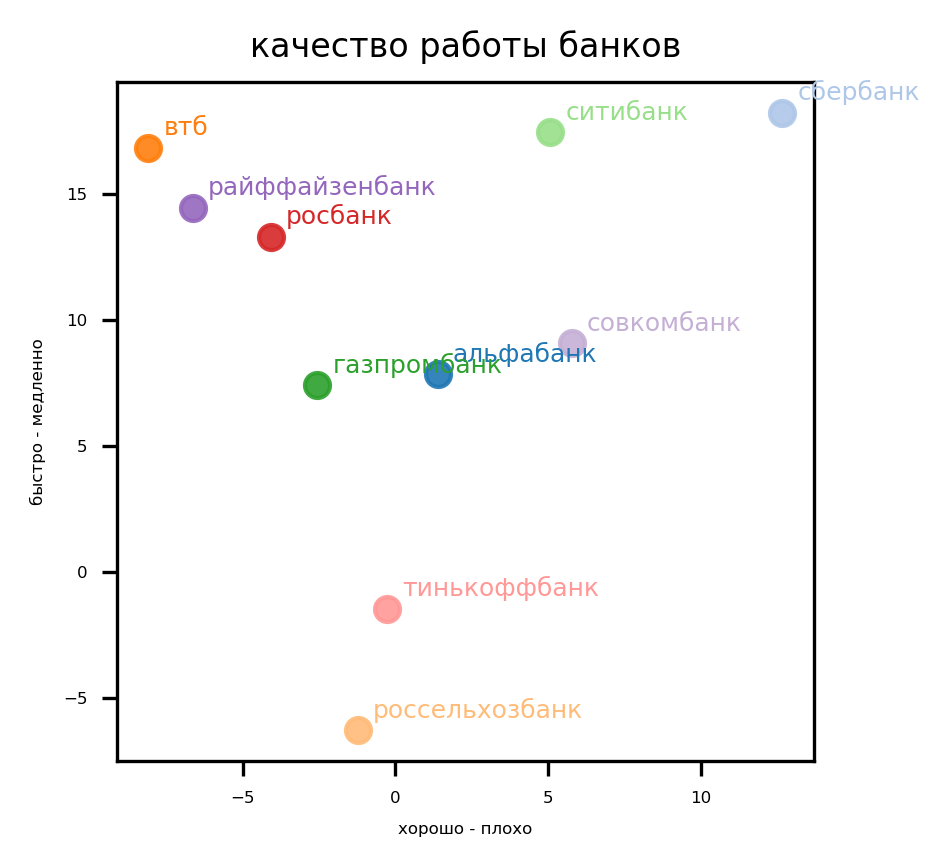

In [262]:
# Визуализируем
colors = plt.cm.tab20.colors

fig = plt.figure(figsize=(3,3), dpi=300)
ax = fig.add_subplot()
fig.subplots_adjust()

ax.set_title('качество работы банков', fontsize=8)

ax.set_xlabel('хорошо - плохо', fontsize=4)
ax.set_ylabel('быстро - медленно', fontsize=4)

for i in range(len(bank_names)):
    ax.text(x[i]+0.5, y[i]+0.5, bank_names[i], color=colors[i%20], fontsize=6)
    ax.scatter(x[i], y[i], alpha=0.9, c=colors[i%20])

    plt.tick_params(axis='both', labelsize=4)
plt.show()

In [277]:
# словарь: model.wv.key_to_index.keys()